In [13]:
import pandas as pd
import torch

from scripts.training import run_epoch, train_loop
from utils import move_data_to_device, move_dict_to_cpu, plot_image, plot_image_boxes
from data_simulator import PsfDataset
from models.subpix_rcnn import SubpixRCNN

import torch.nn as nn
from torchvision.ops import MultiScaleRoIAlign
from torchvision.ops import misc as misc_nn_ops
from torchvision.transforms._presets import ObjectDetection
from torchvision.models._api import register_model, Weights, WeightsEnum
from torchvision.models._meta import _COCO_CATEGORIES
from torchvision.models._utils import _ovewrite_value_param, handle_legacy_interface
from torchvision.models.resnet import resnet50, ResNet50_Weights
from torchvision.models.detection._utils import overwrite_eps
from torchvision.models.detection.backbone_utils import _resnet_fpn_extractor, _validate_trainable_layers
from torchvision.models.detection.faster_rcnn import _default_anchorgen, FasterRCNN, FastRCNNConvFCHead, RPNHead
from torchvision.models.detection.roi_heads import RoIHeads

from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection.generalized_rcnn import GeneralizedRCNN
import torch.nn.functional as F
import torch.optim as optim
from data_simulator import make_one_data
import os
import datetime

In [2]:
# Instantiate the datasets.
num_spots_min = 5
num_spots_max = 5
sigma_mean = 2.0
sigma_std = 0.0
snr_mean = 10
snr_std = 0.2
base_noise_min = 50
base_noise_max = 150
use_gauss_noise = True
gauss_noise_std = 10
img_w, img_h = 64, 64

# Instantiate the datasets.
train_dataset = PsfDataset( 1,
                            200,
                            num_spots_min, num_spots_max,
                            sigma_mean, sigma_std,
                            snr_mean, snr_std,
                            base_noise_min, base_noise_max,
                            use_gauss_noise, gauss_noise_std,
                            img_w, img_h
                          )

valid_dataset = PsfDataset( 2,
                            40,
                            num_spots_min, num_spots_max,
                            sigma_mean, sigma_std,
                            snr_mean, snr_std,
                            base_noise_min, base_noise_max,
                            use_gauss_noise, gauss_noise_std,
                            img_w, img_h
                          )


# Print the number of samples in the training and validation datasets
print(pd.Series({
    'Training dataset size:': len(train_dataset),
    'Validation dataset size:': len(valid_dataset)}))

data_loader_params = {'batch_size':4,    'collate_fn': lambda batch: tuple(zip(*batch)),}

training_loader = torch.utils.data.DataLoader(train_dataset, **data_loader_params)
validation_loader = torch.utils.data.DataLoader(valid_dataset, **data_loader_params)

Training dataset size:      200
Validation dataset size:     40
dtype: int64


In [4]:
def generate_checkpoint_path(model_name, project_name):

  # 1. Define the project directory within Colab's content area
  folder_path = os.path.join(os.curdir, project_name)

  # 2. Create the directory if it doesn't exist
  os.makedirs(folder_path, exist_ok=True)

  # 3. Generate a timestamped subdirectory
  timestamp = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
  checkpoint_dir = os.path.join(folder_path, timestamp)
  os.makedirs(checkpoint_dir, exist_ok=True)

  # 4. Construct the checkpoint path
  checkpoint_path = os.path.join(checkpoint_dir, f"{model_name}.pth")

  return checkpoint_path

In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

backbone = resnet_fpn_backbone("resnet50", pretrained=True)
kwargs = {"nms_tresh": 0.1, "detections_per_img": 5}
model = SubpixRCNN(backbone, num_classes=2, device=device, **kwargs)
model.to(device)
model.name = "testmodel"
optimizer = optim.Adam(model.parameters(), lr=0.001)

checkpoint_path = generate_checkpoint_path("testmodel", "subpix_rcnn")
num_epochs = 5

train_loop(model, training_loader, validation_loader, optimizer, device, num_epochs, checkpoint_path)

Custom SubpixRoIHeads successfully initialized!


Epochs:  20%|██        | 1/5 [00:12<00:49, 12.33s/it]

New best loss: 0.475411182641983


Epochs:  40%|████      | 2/5 [00:24<00:37, 12.34s/it]

New best loss: 0.2770371913909912


Epochs: 100%|██████████| 5/5 [01:00<00:00, 12.17s/it]

New best loss: 0.22518476396799086


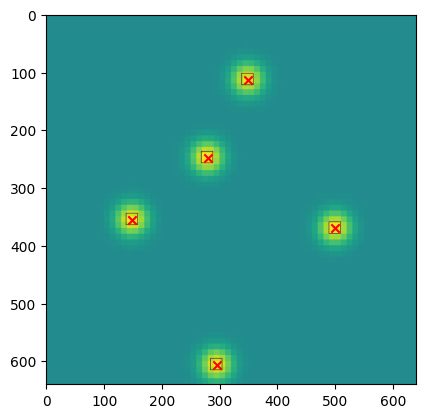

{'boxes': tensor([[13.8389, 34.4918, 15.8389, 36.4918],
        [48.9787, 35.9581, 50.9787, 37.9581],
        [33.8676, 10.2545, 35.8676, 12.2545],
        [26.8987, 23.7785, 28.8987, 25.7785],
        [28.4747, 59.5815, 30.4747, 61.5815]]), 'labels': tensor([1, 1, 1, 1, 1]), 'positions': tensor([[14.8389, 35.4918],
        [49.9787, 36.9581],
        [34.8676, 11.2545],
        [27.8987, 24.7785],
        [29.4747, 60.5815]]), 'subpixel_positions': tensor([[0.8389, 0.4918],
        [0.9787, 0.9581],
        [0.8676, 0.2545],
        [0.8987, 0.7785],
        [0.4747, 0.5815]])}
{'boxes': tensor([[26.8068, 23.7701, 29.0688, 25.7995],
        [33.8099, 10.2392, 36.0469, 12.3005],
        [13.7436, 34.4446, 15.9600, 36.5446],
        [48.8309, 35.9758, 51.1662, 37.9683],
        [28.3230, 59.6096, 30.7062, 61.5841]]), 'labels': tensor([1, 1, 1, 1, 1]), 'scores': tensor([0.9900, 0.9885, 0.9883, 0.9851, 0.9829]), 'subpixel_positions': tensor([[349.2223, 309.8103],
        [436.6055, 140.87

In [15]:
model.to(device='cuda')
device = 'cuda'
model.eval()
img, tar = valid_dataset[2]
img = move_data_to_device(img,device)
tar = move_data_to_device(tar,device)
imgs = []
imgs.append(img)
with torch.no_grad():
  out = model(imgs)

out = out[0]
move_dict_to_cpu(tar)
move_dict_to_cpu(out)
plot_image_boxes(img,tar,None,True,True)
print(tar)
print(out)